# Omics integration in MEWpy

This notebook exemplifies how MEWpy integrates omics data, in this case gene expression data, into the models.
We will apply GIMME and E-Flux algorithms.

GIMME: minimizes usage of low-expression reactions while keeping the objective (e.g., biomass) above a certain value. We need a cutoff value to determine if the reaction is activated or not. It's a binary decision over the reactions.

E-Flux: uses transcriptomic data to set upper and lower bounds on metabolic fluxes. Reactions associated with more highly expressed genes will be allowed to have higher absolute flux values.

Usage in anaerobic simulations:

1. GIMME modifications for glucose uptake with gene expression data
2. GIMME modifications for xylose uptake with gene expression data

#### Packages

In addition to installing cobrapy, pandas and mewpy, we will need "matplotlib" as well.

Open a cell here and run:

pip install matplotlib

After, restart Kernell or open and close the jupyter notebook.

In [1]:
#pip install matplotlib

In [2]:
from cobra.io import read_sbml_model
from mewpy.simulation import get_simulator
import pandas as pd


from mewpy.omics import ExpressionSet
from mewpy.omics import GIMME
from mewpy.omics import eFlux

import matplotlib.pyplot as plt

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-15


Yeast could consumes xylose (5C sugar) after a genetically modification. The XR-XDH pathway is insert, but suffers with xylitol accumulation and cofactor availability.

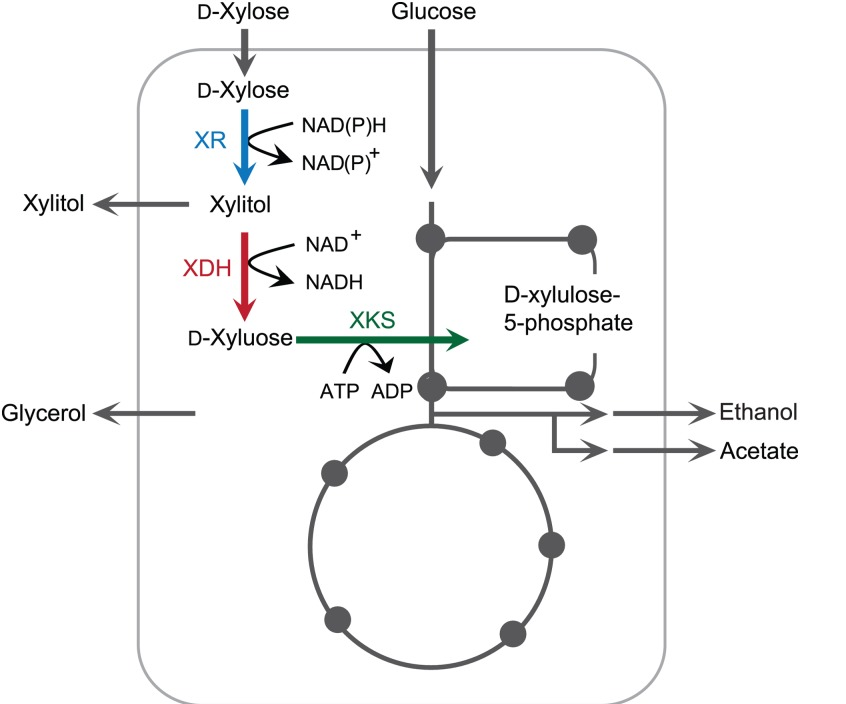

 https://europepmc.org/article/med/23183982

# 1. Default simulation


In [4]:
# Modifications to GLUCOSE anaerobic fermentation. 
# We need to block xylose and oxygen exchange reactions, and change boundaries of sterols reactions.
# Glucose starts with 10 mmol/gDW/h

model = read_sbml_model('data/iMM904.xml')

envcond = {'EX_glc__D_e':(-10,1000), "EX_xyl__D_e":(0,0), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

res = simul.simulate(method="pFBA")
res


objective: 299.2640960248493
Status: OPTIMAL
Constraints: OrderedDict([('EX_glc__D_e', (-10, 1000)), ('EX_xyl__D_e', (0, 0)), ('EX_epist_e', (-1000, 1000)), ('EX_epistest_SC_e', (-1000, 1000)), ('ERGSTt', (-1000, 1000)), ('EX_ergstest_SC_e', (-1000, 1000)), ('EX_fecost_e', (-1000, 1000)), ('EX_lanost_e', (-1000, 1000)), ('EX_lanostest_SC_e', (-1000, 1000)), ('EX_zymst_e', (-1000, 1000)), ('EX_zymstest_SC_e', (-1000, 1000)), ('ERGTETROLter', (-1000, 1000)), ('EX_pc_SC_e', (-1000, 1000)), ('EX_ptd1ino_SC_e', (-1000, 1000)), ('EX_o2_e', (0, 0))])
Method:pFBA

In [5]:
# XR-XDH pathway

res.find(["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"])

,Reaction ID,Flux rate
0,EX_etoh_e,16.743580
1,RPE,-0.061768
2,XYLK,0.000000
3,XYLR,0.000000
4,XYLTD_D,0.000000


In [6]:
# Modifications to XYLOSE anaerobic fermentation. 
# We need to block glucose and oxygen exchange reactions, and change boundaries of sterols reactions.
# Xylose starts with 10 mmol/gDW/h

envcond = {'EX_glc__D_e':(0,0), "EX_xyl__D_e":(-10,1000), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

res = simul.simulate(method="pFBA")
res


objective: 310.28190418373896
Status: OPTIMAL
Constraints: OrderedDict([('EX_glc__D_e', (0, 0)), ('EX_xyl__D_e', (-10, 1000)), ('EX_epist_e', (-1000, 1000)), ('EX_epistest_SC_e', (-1000, 1000)), ('ERGSTt', (-1000, 1000)), ('EX_ergstest_SC_e', (-1000, 1000)), ('EX_fecost_e', (-1000, 1000)), ('EX_lanost_e', (-1000, 1000)), ('EX_lanostest_SC_e', (-1000, 1000)), ('EX_zymst_e', (-1000, 1000)), ('EX_zymstest_SC_e', (-1000, 1000)), ('ERGTETROLter', (-1000, 1000)), ('EX_pc_SC_e', (-1000, 1000)), ('EX_ptd1ino_SC_e', (-1000, 1000)), ('EX_o2_e', (0, 0))])
Method:pFBA

In [7]:
res.find(["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"])

,Reaction ID,Flux rate
0,EX_etoh_e,15.695454
1,RPE,-3.351755
2,XYLK,10.000000
3,XYLR,10.000000
4,XYLTD_D,10.000000


# 2. GIMME


In [8]:
# load expression dataset
expression = pd.read_csv("data/gene_expression_data.txt",sep="\t",index_col=0)
expression.head(5)

,Glucose_medium,Xylose_medium
genes,,
YGR121C,8.75635,12.77670
YIL009W,31.34840,18.60180
YER089C,40.99820,28.90290
YML037C,5.24355,1.31501
YDR383C,7.88679,4.49923


In [10]:
#Example with industrial transcriptomics data during glucose fermentation

envcond = {'EX_glc__D_e':(-10,1000), "EX_xyl__D_e":(0,0), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

#get genes and expression data
genes = expression.index.values
conditions = ["Glucose_medium"]
exp = expression[conditions].to_numpy()

# load expression module
expr = ExpressionSet(genes, conditions, exp)

# Apply parsimonious GIMME in the model
g = GIMME(simul, expr, parsimonious= True)

# Fluxes results
g.values

{'CITtcp': 0.0,
 '13BGH': 0.0,
 '13BGHe': 0.0,
 '13GS': 0.2158356777073319,
 '16GS': 0.0,
 '23CAPPD': 0.0,
 '2DDA7Ptm': 0.0,
 '2DHPtm': 0.0,
 '2DOXG6PP': 0.0,
 '2HBO': 0.0,
 '2HBt2': 0.0,
 '2HMHMBQMTm': 0.0,
 '2HP6MPMOm': 0.0,
 '2HPMBQMTm': 0.0,
 '2HPMMBQMOm': 0.0,
 '2MBACt': 0.0,
 'EX_epistest_SC_e': 0.0,
 'EX_epist_e': 0.0,
 '2MBALDt': 0.0,
 '2MBALDtm': 0.0,
 '2MBTOHt': 0.0,
 'ACACT6p': 0.0,
 '2MBTOHtm': 0.0,
 'ACACT7p': 0.0,
 '2MPPALt': 0.0,
 'ACACT8p': 0.0,
 'ACACT9p': 0.0,
 'ACALDCD': 0.0,
 'ACALDt': 0.0,
 'ACALDtm': 0.0,
 'ACCOAC': 0.004047394497320056,
 'ACCOACrm': 0.0,
 'AGAT_SC': 0.004697868557782074,
 'AGPRim': 0.030564675191723862,
 'AGTi': 0.0,
 'AHCYStm': 0.0,
 'ACCOAtn': 0.0,
 '2MPPALtm': 0.0,
 'ACESt': 0.0,
 'ACGAM6PS': 0.0,
 'AHCi': 0.0,
 'AHMMPS': 0.0,
 'AHSERL': 0.0,
 'AHSERL2': 0.010898294265624001,
 'ACGAMPM': 0.0,
 'ACGKm': 0.030564675191723862,
 '2OBUTtm': 0.036650982685387135,
 'ACGSm': 0.0,
 '2OXOADPtim': 0.054434412195839256,
 'ACHBSm': 0.036650982635004284,
 '

In [12]:
#results to dataframe

res_glu = g.to_dataframe()
res_glu.columns = ["glu_fluxes"]
res_glu

,glu_fluxes
CITtcp,0.000000
13BGH,0.000000
13BGHe,0.000000
13GS,0.215836
16GS,0.000000
...,...
PYDXO,0.000000
PYK,16.778024
PYNP2r,0.000000
PYR5CDm,0.000000


In [14]:
#pandas skill

res_glu.loc[["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"]]

,glu_fluxes
XYLR,0.000000
XYLTD_D,0.000000
XYLK,0.000000
RPE,-0.055591
EX_etoh_e,15.389098


In [15]:
#Example with industrial transcriptomics data during xylose fermentation

envcond = {'EX_glc__D_e':(0,0), "EX_xyl__D_e":(-10.0,1000), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

#get genes and expression data
genes = expression.index.values
conditions = ["Xylose_medium"]
exp = expression[conditions].to_numpy()

# load expression module
expr = ExpressionSet(genes, conditions, exp)

# Apply parsimonious GIMME in the model
g = GIMME(simul, expr, parsimonious=True)

# Fluxes results
g.values

{'CITtcp': 0.0,
 '13BGH': 0.0,
 '13BGHe': 0.0,
 '13GS': 0.06437204422850017,
 '16GS': 0.0,
 '23CAPPD': 0.0,
 '2DDA7Ptm': 0.0,
 '2DHPtm': 0.0,
 '2DOXG6PP': 0.0,
 '2HBO': 0.0,
 '2HBt2': 0.0,
 '2HMHMBQMTm': 0.0,
 '2HP6MPMOm': 0.0,
 '2HPMBQMTm': 0.0,
 '2HPMMBQMOm': 0.0,
 '2MBACt': 0.0,
 'EX_epistest_SC_e': 0.0,
 'EX_epist_e': 0.0,
 '2MBALDt': 0.0,
 '2MBALDtm': 0.0,
 '2MBTOHt': 0.0,
 'ACACT6p': 0.0,
 '2MBTOHtm': 0.0,
 'ACACT7p': 0.0,
 '2MPPALt': 0.0,
 'ACACT8p': 0.0,
 'ACACT9p': 0.0,
 'ACALDCD': 0.0,
 'ACALDt': 0.0,
 'ACALDtm': 0.0,
 'ACCOAC': 0.0012071176897734404,
 'ACCOACrm': 0.0,
 'AGAT_SC': 0.0014011186926717965,
 'AGPRim': 0.009115780320338366,
 'AGTi': 0.0,
 'AHCYStm': 0.0,
 'ACCOAtn': 0.0,
 '2MPPALtm': 0.0,
 'ACESt': 0.0,
 'ACGAM6PS': 0.0,
 'AHCi': 0.0,
 'AHMMPS': 0.0,
 'AHSERL': 0.0,
 'AHSERL2': 0.0032503684651859887,
 'ACGAMPM': 0.0,
 'ACGKm': 0.009115780320338366,
 '2OBUTtm': 0.010930994874797761,
 'ACGSm': 0.0,
 '2OXOADPtim': 0.01623482468998656,
 'ACHBSm': 0.010930994820965795,

In [16]:
#results to dataframe

res_xyl = g.to_dataframe()
res_xyl.columns = ["xyl_fluxes"]
res_xyl

,xyl_fluxes
CITtcp,0.000000
13BGH,0.000000
13BGHe,0.000000
13GS,0.064372
16GS,0.000000
...,...
PYDXO,0.000000
PYK,14.855726
PYNP2r,0.000000
PYR5CDm,0.000000


In [17]:
#pandas skill

res_xyl.loc[["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"]]

,xyl_fluxes
XYLR,9.150000
XYLTD_D,9.150000
XYLK,9.150000
RPE,-3.066580
EX_etoh_e,14.375908


# 3. Escher maps

Lets take a look at the fluxes using Escher maps

In [18]:
import escher
from escher import Builder

In [19]:
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [20]:
# Selecting for S. cerevisiae 

builder = Builder(
    map_name='iMM904.Central carbon metabolism',
    model_name='iMM904',
)
builder

Builder()

In [21]:
#Glucose with parsimonious GIMME fluxes

builder.model = model
builder.reaction_data = res_glu

In [22]:
# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = False
builder.hide_all_labels = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 12 },
    { 'type': 'median', 'color': '#ffffff', 'size': 20 },
    { 'type': 'max', 'color': '#ff0000', 'size': 25 }
]
builder.reaction_scale_preset = 'GaBuRd'

# Make all the arrows three times as thick
builder.reaction_scale = [
    {k: v * 3 if k == 'size' else v for k, v in x.items()}
    for x in builder.reaction_scale
]

#plot

builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [35]:
#Xylose with parsimonius GIMME fluxes

builder.model = model
builder.reaction_data = res_xyl

In [39]:
# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = False
builder.hide_all_labels = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 12 },
    { 'type': 'median', 'color': '#ffffff', 'size': 20 },
    { 'type': 'max', 'color': '#ff0000', 'size': 25 }
]
builder.reaction_scale_preset = 'GaBuRd'

# Make all the arrows three times as thick
builder.reaction_scale = [
    {k: v * 3 if k == 'size' else v for k, v in x.items()}
    for x in builder.reaction_scale
]

#plot

builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

# 4. Comparing the results


In [26]:
# join:  join two datasets. They must have the same rownames.

final_result = res_glu.join(res_xyl)
final_result.head(10)

,glu_fluxes,xyl_fluxes
CITtcp,0.000000,0.000000
13BGH,0.000000,0.000000
13BGHe,0.000000,0.000000
13GS,0.215836,0.064372
16GS,0.000000,0.000000
23CAPPD,0.000000,0.000000
2DDA7Ptm,0.000000,0.000000
2DHPtm,0.000000,0.000000
2DOXG6PP,0.000000,0.000000
2HBO,0.000000,0.000000


In [27]:
# create a column called "delta" with differences

final_result["delta"] = final_result["glu_fluxes"] - final_result["xyl_fluxes"]
final_result

,glu_fluxes,xyl_fluxes,delta
CITtcp,0.000000,0.000000,0.000000
13BGH,0.000000,0.000000,0.000000
13BGHe,0.000000,0.000000,0.000000
13GS,0.215836,0.064372,0.151464
16GS,0.000000,0.000000,0.000000
...,...,...,...
PYDXO,0.000000,0.000000,0.000000
PYK,16.778024,14.855726,1.922297
PYNP2r,0.000000,0.000000,0.000000
PYR5CDm,0.000000,0.000000,0.000000


In [28]:
# select reactions with difference (column "delta" > 0.5)

select =[]

for index, row in final_result.iterrows():
    res = row['delta']

    if abs(res) > 0.5:
        select.append(index)
        
select

['ACt2r',
 'ACtr',
 'ALCD2x_copy2',
 'CO2t',
 'CO2tm',
 'DHAK',
 'ENO',
 'ETOHt',
 'EX_etoh_e',
 'EX_glc__D_e',
 'EX_h2o_e',
 'EX_h_e',
 'EX_co2_e',
 'EX_nh4_e',
 'EX_xyl__D_e',
 'G3PT',
 'GLUSx',
 'GAPD',
 'GLYCDy',
 'FBA',
 'GLCt1',
 'FBA3',
 'GLNS',
 'H2Ot',
 'HCO3E',
 'HEX1',
 'NH4t',
 'G3PD1ir',
 'PFK',
 'PFK_3',
 'PGI',
 'PGK',
 'PGM',
 'PC',
 'PPA',
 'RPE',
 'RPI',
 'TKT1',
 'TKT2',
 'TPI',
 'XYLK',
 'XYLR',
 'XYLTD_D',
 'XYLt',
 'PYK',
 'PYRDC']

In [29]:
# selecting rows for interesting reactions. Only the "delta" column.
final_result2 = final_result.loc[select]["delta"].to_frame()

# create a column called "color" based on the difference over the fluxes
final_result2['colors'] = ['red' if x < 0 else 'blue' for x in final_result2['delta']]

#sorting values by "delta" column
final_result2.sort_values('delta', inplace=True)

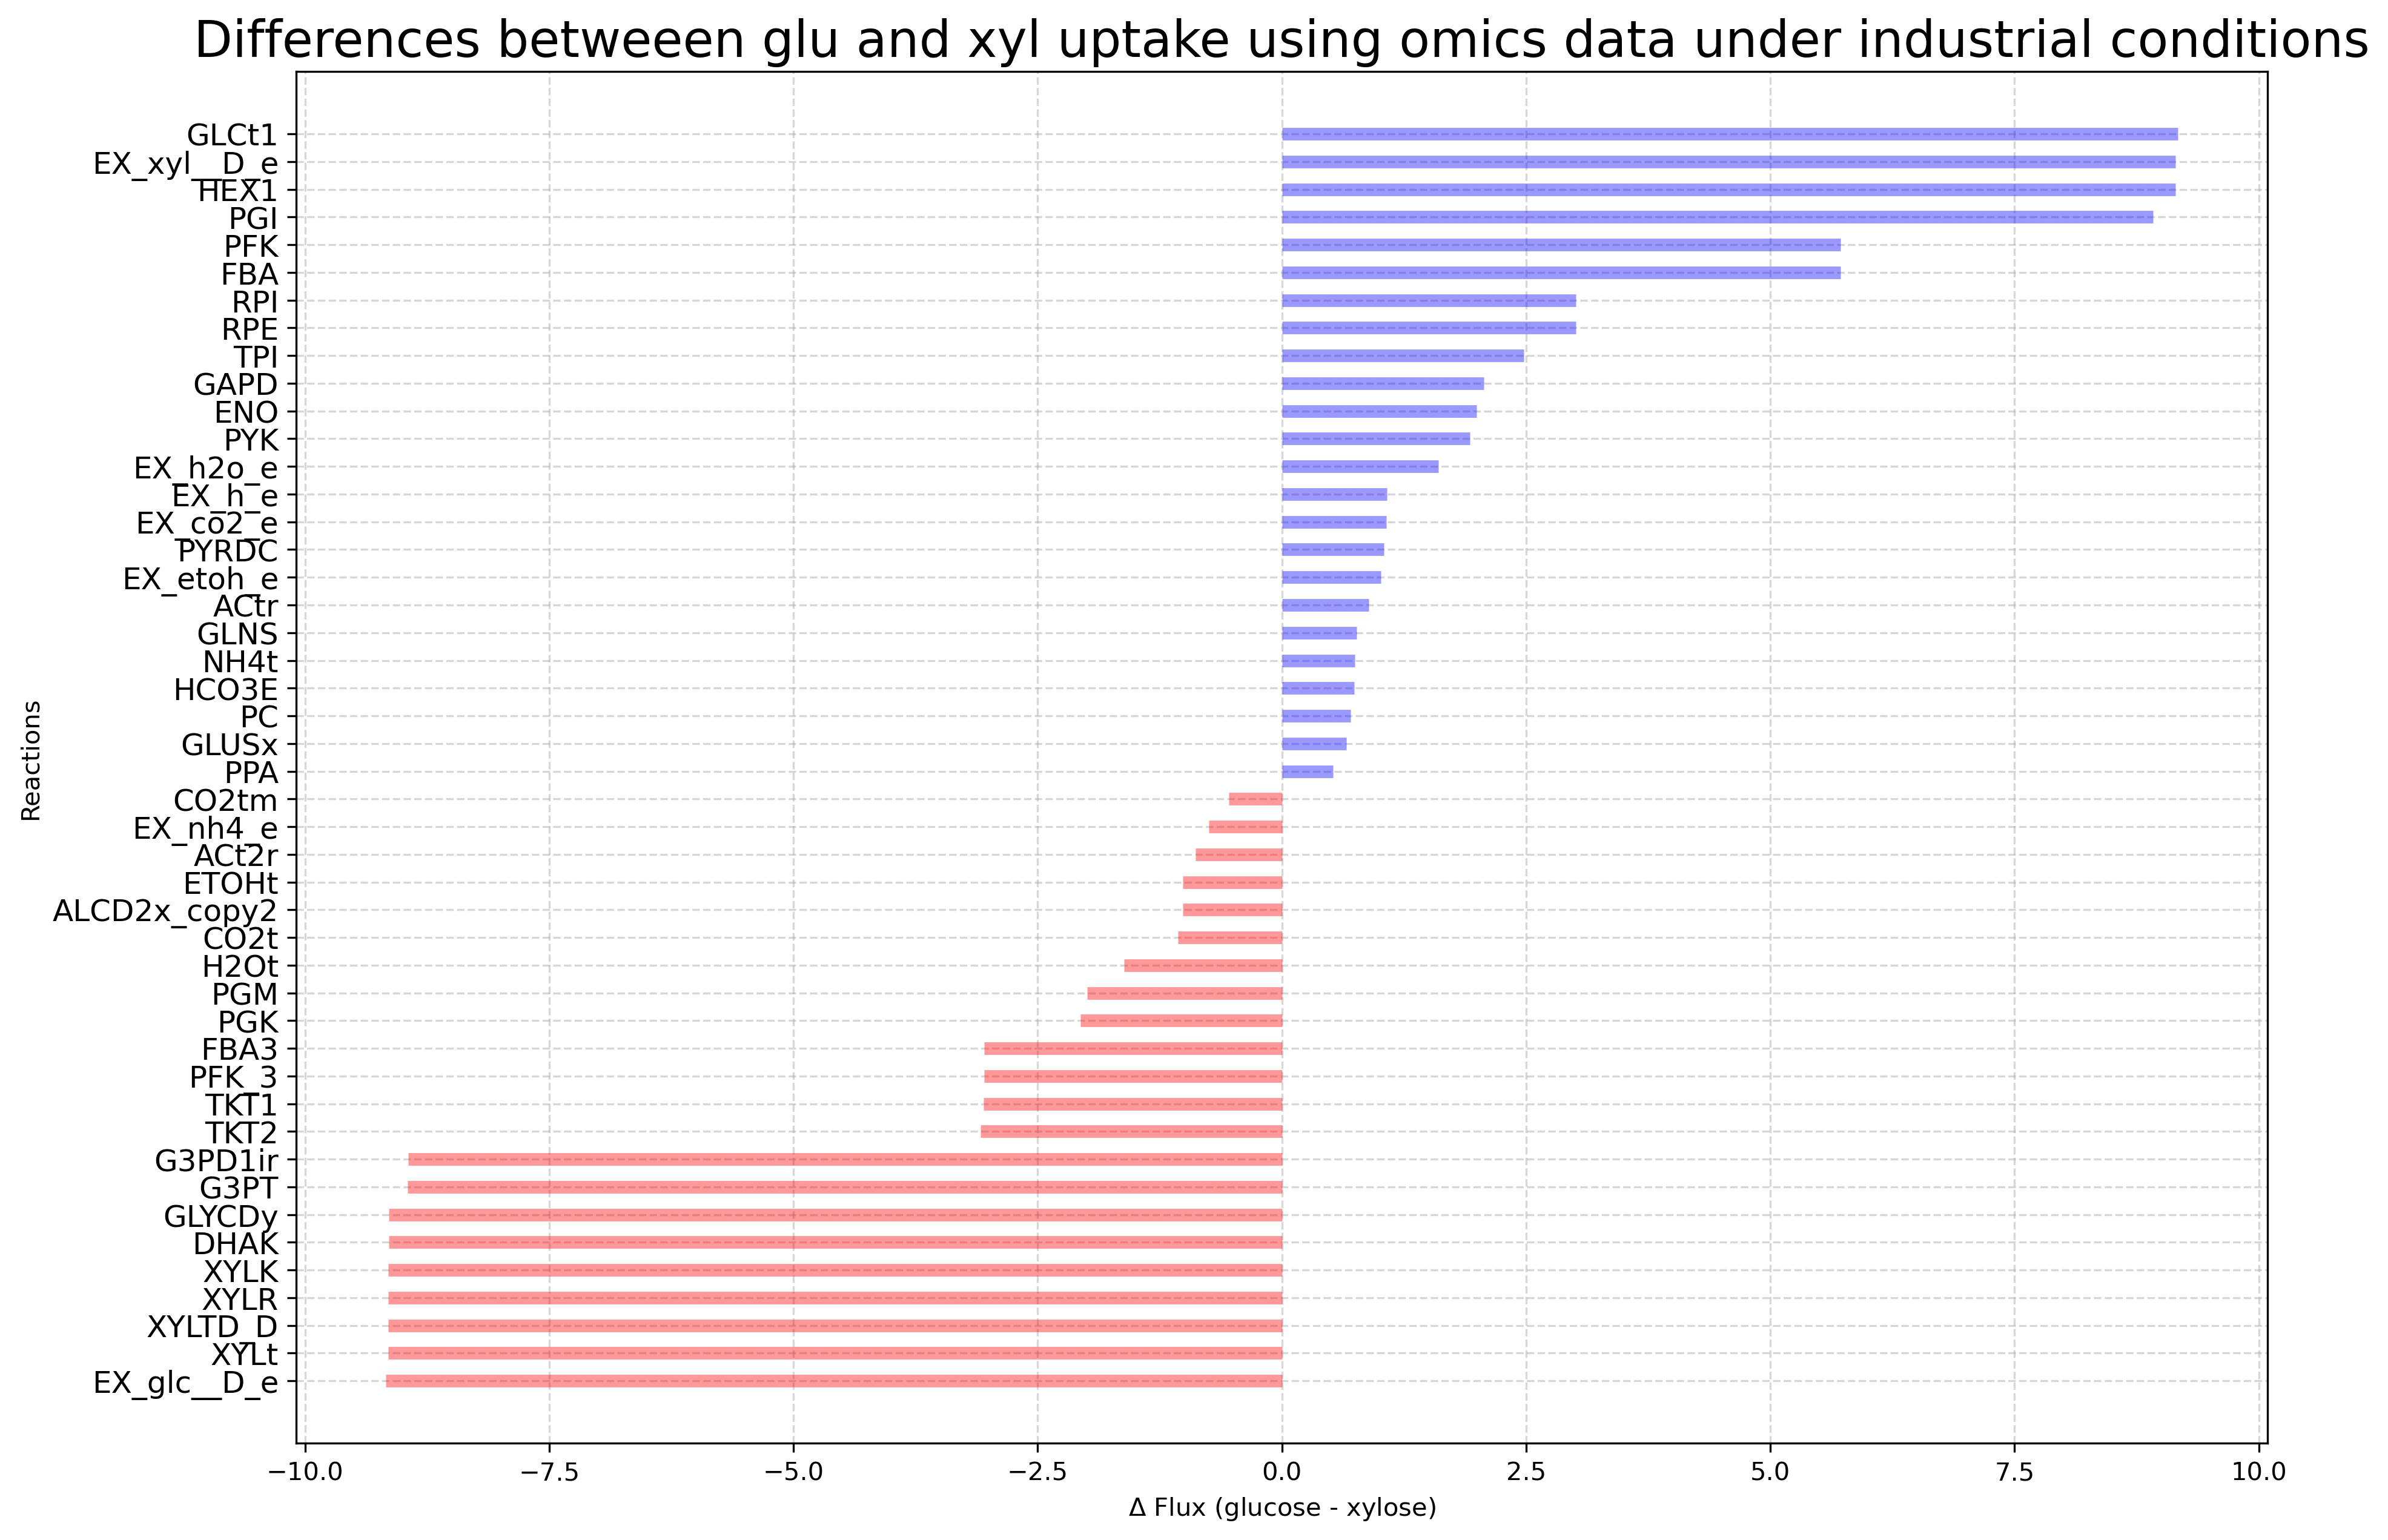

In [32]:
# Draw plot with horizontal lines (plt.hlines of matplotlib)
fig= plt.figure(figsize=(14,10), dpi= 300)
plt.hlines(y=final_result2.index, xmin=0, xmax=final_result2["delta"], color=final_result2.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='Reactions', xlabel='$\Delta$ Flux (glucose - xylose)')
plt.yticks(final_result2.index, fontsize=12)
plt.title('Differences betweeen glu and xyl uptake using omics data under industrial conditions', 
          fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [33]:
# Saving image

fig.savefig("GIMME_glu_xyl.png")

In [31]:
#Ethanol

final_result.loc[["EX_etoh_e"]]

,glu_fluxes,xyl_fluxes,delta
EX_etoh_e,15.389098,14.375908,1.013189


# Exercise

1. Load the model;
2. Create a simulation for anaerobic environment;
3. Apply E-Flux algorithm. You can substitute the method using:
    - g = eFlux(simul, expr,parsimonious=True)
4. Compare the results